In [1]:
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

# Simple NST/ Image Regeneration (Content part only) from VGG-19

- input: target image
- output: generate image like target image from noise image by using gradient descent

## References

- https://keras.io/examples/generative/neural_style_transfer/

# Load VGG-19 Model

In [2]:
# neural style transfer output

content_layers = ['block5_conv2']
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1',
]

In [3]:
def load_vgg():
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    # vgg.trainable = False
    
    # extracted feature
    layers = content_layers + style_layers
    outputs_dict = dict([(layer, vgg.get_layer(layer).output) for layer in layers])
    
    # model for nst
    feature_extractor = tf.keras.Model(inputs=vgg.input, outputs=outputs_dict)
    
    return feature_extractor

# Image Preprocessing

In [4]:
def preprocess_image(image_path, image_size=(500, 500)):
    """
        return: tensor type array. shape (1, height, width, channel).
    """
    
    
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=image_size 
    )
    
    # image to numpy array shape (h, w, c)
    img = tf.keras.preprocessing.image.img_to_array(img)
    
    # to shape (1, h, w, c)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    
    return tf.convert_to_tensor(img)

In [5]:
def deprocess_image(tensor_img):
    img = np.array(tensor_img.numpy()[0], dtype=np.float64)
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")

    return img

In [6]:
img_path = "./img/2valk.jpg"
img_tensor = preprocess_image(img_path)

In [7]:
img_tensor

<tf.Tensor: shape=(1, 500, 500, 3), dtype=float32, numpy=
array([[[[  26.060997 ,   -0.7789993,  -13.68     ],
         [  42.060997 ,   14.221001 ,    4.3199997],
         [  70.061    ,   42.221    ,   33.32     ],
         ...,
         [ -57.939003 ,  -89.779    , -104.68     ],
         [ -53.939003 ,  -85.779    , -100.68     ],
         [ -57.939003 ,  -89.779    , -104.68     ]],

        [[  44.060997 ,   21.221    ,   -2.6800003],
         [  73.061    ,   50.221    ,   26.32     ],
         [  36.060997 ,   13.221001 ,  -10.68     ],
         ...,
         [ -47.939003 ,  -83.779    ,  -98.68     ],
         [ -49.939003 ,  -85.779    , -100.68     ],
         [ -48.939003 ,  -84.779    ,  -99.68     ]],

        [[  80.061    ,   55.221    ,   42.32     ],
         [  59.060997 ,   33.221    ,   12.32     ],
         [  61.060997 ,   38.221    ,   14.32     ],
         ...,
         [ -44.939003 ,  -84.779    , -101.68     ],
         [ -50.939003 ,  -90.779    , -107.68   

In [8]:
img_np = deprocess_image(img_tensor)

In [9]:
img_np

array([[[109, 116, 129],
        [127, 131, 145],
        [156, 159, 173],
        ...,
        [ 18,  27,  45],
        [ 22,  31,  49],
        [ 18,  27,  45]],

       [[120, 138, 147],
        [149, 167, 176],
        [112, 130, 139],
        ...,
        [ 24,  33,  55],
        [ 22,  31,  53],
        [ 23,  32,  54]],

       [[165, 172, 183],
        [135, 150, 162],
        [137, 155, 164],
        ...,
        [ 21,  32,  58],
        [ 15,  26,  52],
        [ 20,  31,  57]],

       ...,

       [[ 59,  58,  60],
        [ 65,  64,  66],
        [ 69,  68,  70],
        ...,
        [217, 183, 152],
        [217, 187, 155],
        [213, 184, 149]],

       [[ 66,  65,  67],
        [ 60,  59,  61],
        [ 53,  52,  54],
        ...,
        [207, 167, 134],
        [199, 165, 132],
        [218, 185, 149]],

       [[ 71,  70,  72],
        [ 64,  63,  65],
        [ 72,  71,  73],
        ...,
        [169, 122,  83],
        [168, 125,  87],
        [198, 156, 120]]

# Generated Image Tensor

In [10]:
def load_random_noise_tensor(img_tensor):
    random_noise = np.array(np.random.randint(0, 255, img_tensor.shape))
    gen_tensor = tf.Variable(random_noise, dtype=tf.float32)
    return gen_tensor

In [11]:
gen_tensor = load_random_noise_tensor(img_tensor)

# Compute Loss

In [12]:
def compute_content_loss(base_tensor, gen_tensor, content_layer='block1_conv1', loss_weight=1e-6):
    input_tensor = tf.concat([base_tensor, gen_tensor], axis=0)
    features = model(input_tensor)[content_layer]
    base_feature = features[0]
    gen_feature = features[1] 
    
    return loss_weight*tf.reduce_sum(tf.square(base_feature - gen_feature))

In [13]:
model = load_vgg()

In [14]:
# content layer
content_layer = 'block1_conv1'
output = model(img_tensor)

In [15]:
compute_content_loss(img_tensor, img_tensor)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

# Gradient

In [16]:
@tf.function
def compute_loss_and_grads(base_image_tensor, gen_image_tensor):
    with tf.GradientTape() as tape:
        loss = compute_content_loss(base_image_tensor, gen_image_tensor)
    grads = tape.gradient(loss, gen_image_tensor)
    return loss, grads

# Training Loop

In [17]:
def training_loop(base_tensor, gen_tensor, optimizer, max_iterations=10000):
    for i in range(1, max_iterations+1):
        if (i % 100 == 0) or (i == 1) or (i == max_iterations):
            loss, grads = compute_loss_and_grads(base_tensor, gen_tensor)
            optimizer.apply_gradients([(grads, gen_tensor)])
            print(f"iteration {i:8}, loss {loss:.2f}")
            
        # show image
        if (i % 1000 == 0) or (i == 1) or (i == max_iterations):
            fig = plt.figure(figsize=(5, 5))
            plt.title(f"iteration {i}")
            plt.imshow(deprocess_image(gen_tensor))
            plt.show()
        
        # save image
        if (i % 25 == 0) or (i == 1) or (i == max_iterations):
            save_img_arr = deprocess_image(gen_tensor)
            tf.keras.preprocessing.image.save_img(f"./regenerate_output_img/{i}.jpg", save_img_arr)
    
    fig = plt.figure(figsize=(5, 5))
    plt.title("final result")
    plt.imshow(deprocess_image(gen_tensor))
    plt.show()

In [18]:
optimizer = tf.keras.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=10.0, decay_steps=100, decay_rate=0.96
    )
)

In [19]:
# load image
img_path = "./img/remember.jpg"
img_size = (800, 800)

# base image/target image tensor
img_tensor = preprocess_image(img_path, img_size)
# random image
gen_tensor = load_random_noise_tensor(img_tensor)

iteration        1, loss 286538.28


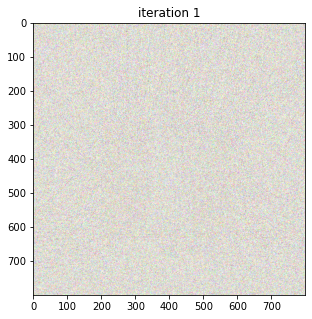

iteration      100, loss 244493.98
iteration      200, loss 208400.78
iteration      300, loss 177226.31
iteration      400, loss 150523.97
iteration      500, loss 128117.48
iteration      600, loss 109765.16
iteration      700, loss 95028.05
iteration      800, loss 83339.56
iteration      900, loss 74092.55
iteration     1000, loss 66732.05


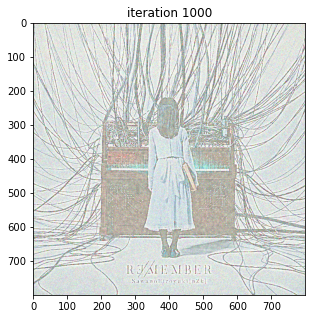

iteration     1100, loss 60782.70
iteration     1200, loss 55857.85
iteration     1300, loss 51657.88
iteration     1400, loss 47960.17
iteration     1500, loss 44606.30
iteration     1600, loss 41488.72
iteration     1700, loss 38537.31
iteration     1800, loss 35708.57
iteration     1900, loss 32978.44
iteration     2000, loss 30335.60


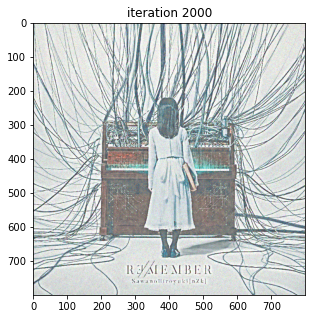

iteration     2100, loss 27775.31
iteration     2200, loss 25300.09
iteration     2300, loss 22919.51
iteration     2400, loss 20649.06
iteration     2500, loss 18508.96
iteration     2600, loss 16517.88
iteration     2700, loss 14688.21
iteration     2800, loss 13025.24
iteration     2900, loss 11528.73
iteration     3000, loss 10194.15


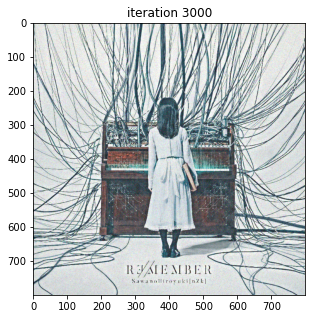

iteration     3100, loss 9013.73
iteration     3200, loss 7977.60
iteration     3300, loss 7074.19
iteration     3400, loss 6290.85
iteration     3500, loss 5614.66
iteration     3600, loss 5032.74
iteration     3700, loss 4533.02
iteration     3800, loss 4104.36
iteration     3900, loss 3736.71
iteration     4000, loss 3421.22


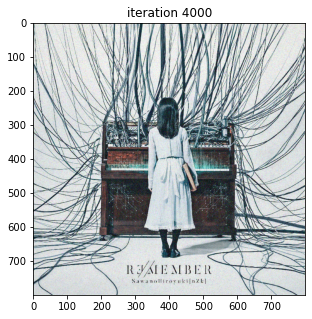

iteration     4100, loss 3150.20
iteration     4200, loss 2916.92
iteration     4300, loss 2715.34
iteration     4400, loss 2540.22
iteration     4500, loss 2387.01
iteration     4600, loss 2251.82
iteration     4700, loss 2131.37
iteration     4800, loss 2022.87
iteration     4900, loss 1923.92
iteration     5000, loss 1832.52


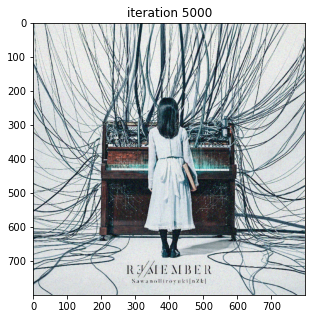

iteration     5100, loss 1747.07
iteration     5200, loss 1666.33
iteration     5300, loss 1589.34
iteration     5400, loss 1515.42
iteration     5500, loss 1444.16
iteration     5600, loss 1375.30
iteration     5700, loss 1308.74
iteration     5800, loss 1244.47
iteration     5900, loss 1182.61
iteration     6000, loss 1123.32


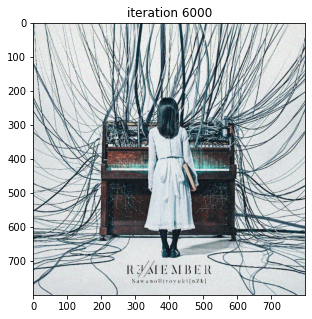

iteration     6100, loss 1066.74
iteration     6200, loss 1013.01
iteration     6300, loss 962.24
iteration     6400, loss 914.50
iteration     6500, loss 869.83
iteration     6600, loss 828.19
iteration     6700, loss 789.52
iteration     6800, loss 753.68
iteration     6900, loss 720.53
iteration     7000, loss 689.87


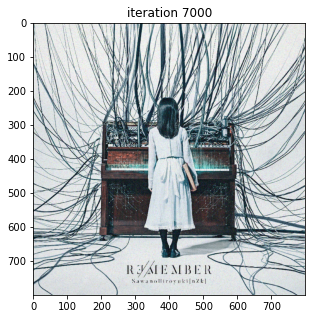

iteration     7100, loss 661.53
iteration     7200, loss 635.32
iteration     7300, loss 611.04
iteration     7400, loss 588.53
iteration     7500, loss 567.59
iteration     7600, loss 548.06
iteration     7700, loss 529.80
iteration     7800, loss 512.66
iteration     7900, loss 496.53
iteration     8000, loss 481.30


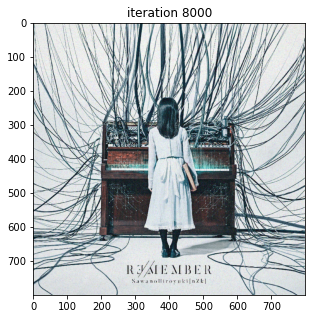

iteration     8100, loss 466.89
iteration     8200, loss 453.24
iteration     8300, loss 440.28
iteration     8400, loss 427.95
iteration     8500, loss 416.22
iteration     8600, loss 405.04
iteration     8700, loss 394.38
iteration     8800, loss 384.21
iteration     8900, loss 374.49
iteration     9000, loss 365.22


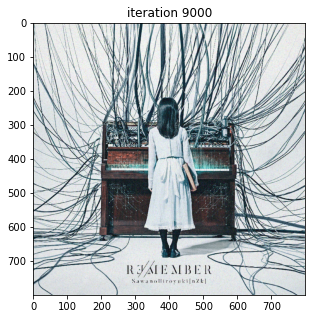

iteration     9100, loss 356.36
iteration     9200, loss 347.89
iteration     9300, loss 339.79
iteration     9400, loss 332.03
iteration     9500, loss 324.61
iteration     9600, loss 317.48
iteration     9700, loss 310.64
iteration     9800, loss 304.07
iteration     9900, loss 297.74
iteration    10000, loss 291.65


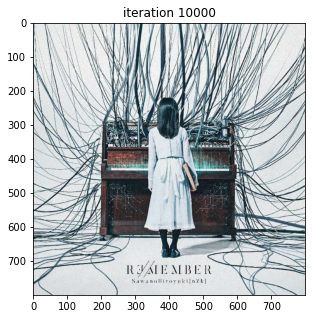

iteration    10100, loss 285.78
iteration    10200, loss 280.11
iteration    10300, loss 274.63
iteration    10400, loss 269.33
iteration    10500, loss 264.20
iteration    10600, loss 259.22
iteration    10700, loss 254.39
iteration    10800, loss 249.71
iteration    10900, loss 245.16
iteration    11000, loss 240.75


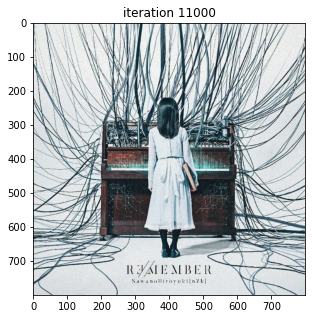

iteration    11100, loss 236.46
iteration    11200, loss 232.29
iteration    11300, loss 228.25
iteration    11400, loss 224.31
iteration    11500, loss 220.49
iteration    11600, loss 216.77
iteration    11700, loss 213.15
iteration    11800, loss 209.63
iteration    11900, loss 206.21
iteration    12000, loss 202.88


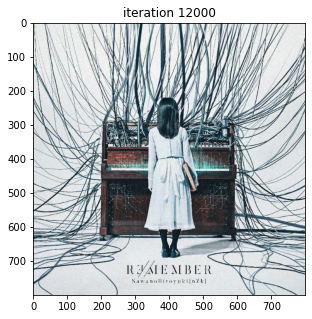

iteration    12100, loss 199.63
iteration    12200, loss 196.47
iteration    12300, loss 193.39
iteration    12400, loss 190.39
iteration    12500, loss 187.47
iteration    12600, loss 184.61
iteration    12700, loss 181.83
iteration    12800, loss 179.11
iteration    12900, loss 176.46
iteration    13000, loss 173.87


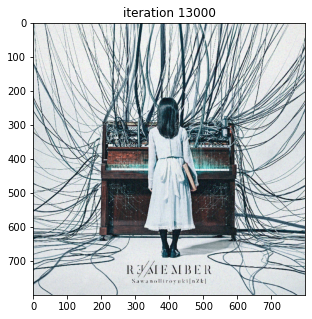

iteration    13100, loss 171.33
iteration    13200, loss 168.86
iteration    13300, loss 166.44
iteration    13400, loss 164.07
iteration    13500, loss 161.76
iteration    13600, loss 159.49
iteration    13700, loss 157.28
iteration    13800, loss 155.11
iteration    13900, loss 152.99
iteration    14000, loss 150.91


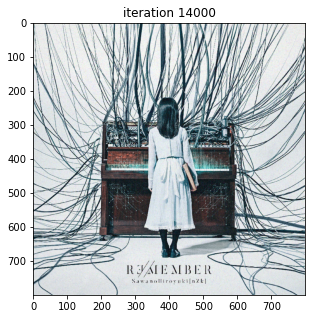

iteration    14100, loss 148.88
iteration    14200, loss 146.88
iteration    14300, loss 144.93
iteration    14400, loss 143.02
iteration    14500, loss 141.15
iteration    14600, loss 139.32
iteration    14700, loss 137.52
iteration    14800, loss 135.76
iteration    14900, loss 134.03
iteration    15000, loss 132.34


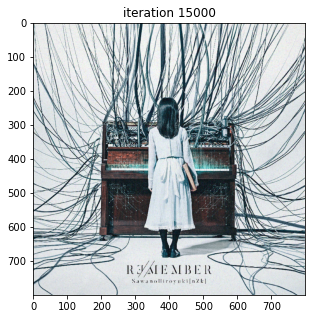

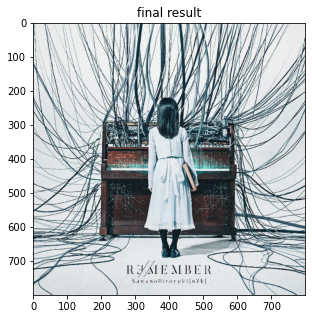

In [20]:
training_loop(img_tensor, gen_tensor, optimizer, 15000)

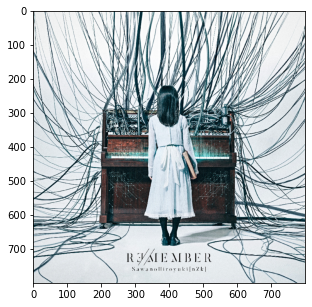

In [21]:
fig = plt.figure(figsize=(5, 5))
plt.imshow(deprocess_image(img_tensor))
plt.show()

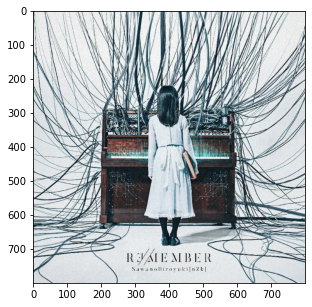

In [22]:
fig = plt.figure(figsize=(5, 5))
plt.imshow(deprocess_image(gen_tensor))
plt.show()